In [168]:
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import datetime

plt.rcParams["figure.figsize"] = (20, 5)

In [169]:
original = np.genfromtxt("../로그 데이터/SEG_SGEMM_result.txt", delimiter="\n", dtype=np.int64)
original

array([ 3196231680, 93292771632, 93293300344, ..., 92658792872,
       92658792864, 92654987192], dtype=int64)

In [170]:
from sklearn.model_selection import train_test_split

data, test_set = train_test_split(original, test_size=0.25, shuffle=False)

In [171]:
delta = np.array([data[i+1] - data[i] for i in range(int(len(data))-1)])
delta, len(delta)

(array([90096539952,      528712,       73032, ...,  5992956672,
         -753929088,   639534672], dtype=int64),
 177895)

In [172]:
data_counts = pd.Series(data=delta.T).value_counts()
data_counts

 0            25834
 4096          5570
 909517620     1849
-909517620     1848
 8192          1076
              ...  
 192498972        1
-22159845         1
-474950960        1
-8649184          1
-654535216        1
Length: 51760, dtype: int64

In [173]:
def category_by_threshold(data_counts, threshold, sign="over"):
    if sign == "under":
        category = (data_counts < threshold)
    else:
        category = (data_counts > threshold)
    return category.index[category == True]

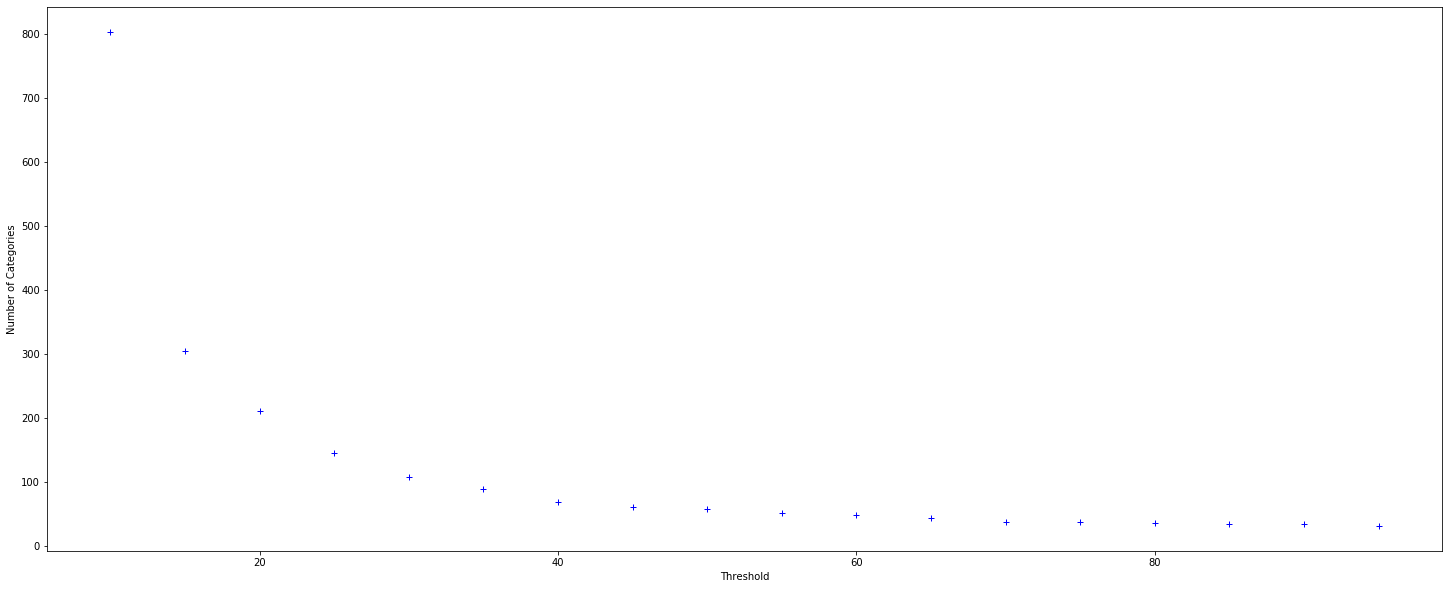

In [174]:
plt.figure(figsize=(25, 10))
data_over_threshold_incremental = pd.DataFrame(data=[(data_counts > i*5).value_counts().values for i in range(2, 20)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i*5 for i in range(2, 20)], data_over_threshold_incremental["Over Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

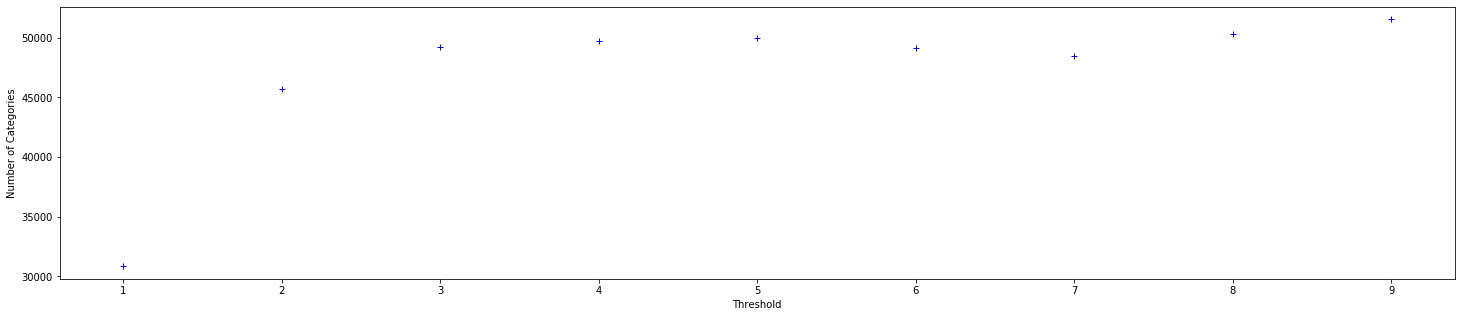

In [175]:
plt.figure(figsize=(25, 5))
data_under_threshold_incremental = pd.DataFrame(data=[(data_counts == i).value_counts().values for i in range(1, 10)], columns=["Under Threshold", "Over Threshold"])
plt.plot([i for i in range(1, 10)], data_under_threshold_incremental["Under Threshold"], "b+")
plt.xlabel("Threshold")
plt.ylabel("Number of Categories")
plt.show()

In [176]:
data_under_threshold_incremental

,Under Threshold,Over Threshold
0,30833,20927
1,45715,6045
2,49187,2573
3,49695,2065
4,49994,1766
5,49107,2653
6,48498,3262
7,50322,1438
8,51544,216


In [177]:
# Num of categories whose occurence is 1
(data_counts == 1).value_counts()[True]

30833

In [178]:
# Upper limit of model if ignore categories whose occurenece is 1
(data_counts == 1).value_counts()[True] / delta.shape[0]

0.17332134124061946

In [179]:
# Num of Categories with occurence i
[(data_counts == i).value_counts()[True] for i in range(1, 10)]

[30833, 6045, 2573, 2065, 1766, 2653, 3262, 1438, 216]

In [180]:
# Num of Delta points of given Category
[(data_counts == i).value_counts()[True] * i for i in range(1, 10)]

[30833, 12090, 7719, 8260, 8830, 15918, 22834, 11504, 1944]

In [181]:
total_noise_delta = sum([(data_counts == i).value_counts()[True] * i for i in range(1, 4)])
total_noise_delta, total_noise_delta / delta.shape[0]

(50642, 0.28467354338233225)

In [182]:
def tokenizer(input_data, target, oov=-1):
    """
    Substitute data points to {oov} that are in categories whose occurence is under {target}
    NOTICE : data is copied before transformed
    """
    data = input_data.copy()
    for i in range(1, target+1):
        mask = (pd.Series(data).value_counts() == i)
        noise_index = np.where(np.isin(data, mask.index[mask == True]))[0]
        data[noise_index] = oov
    return data

In [209]:
tokenized_data = tokenizer(delta, 2)
tokenized_data_counts = pd.Series(tokenized_data).value_counts()
tokenized_data_counts

-1              42931
 0              25834
 4096            5570
 909517620       1849
-909517620       1848
                ...  
 83427458722        3
 4730520            3
-7445040            3
 12889736           3
 619958144          3
Length: 14882, dtype: int64

vocab_index = data_counts.index[data_counts >= 20]
vocab_index

In [210]:
vocab_size = len(tokenized_data_counts.index)
vocab_size

14882

In [185]:
# Int Array to String Array
str_delta = np.char.mod('%d', denoised_delta)
str_delta

array(['-1', '-1', '-1', ..., '-1', '-8', '-1'], dtype='<U12')

In [212]:
# Encoding
#word_index = {vocab_index[i]:i for i in range(vocab_size)}
word_index = {tokenized_data_counts.index[i]:i for i in range(vocab_size)}
dict(list(word_index.items())[0:10])

{-1: 0,
 0: 1,
 4096: 2,
 909517620: 3,
 -909517620: 4,
 8192: 5,
 -8: 6,
 -4096: 7,
 8: 8,
 12288: 9}

In [222]:
preprocessed_data = [word_index[tokenized_data[i]] for i in range(vocab_size)]
preprocessed_data[30:45]

[0, 0, 0, 0, 13354, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [223]:
# check
tokenized_data[30:45]

array([  -1,   -1,   -1,   -1, 9536,   -1,   -1,   -1,   -1,   -1,   -1,
         -1,   -1,   -1,   -1], dtype=int64)

In [229]:
# check
word_index[9536]

13354

In [233]:
# Decoding
list(word_index.keys())[13354]

9536

In [235]:
np.savetxt("data/word_index.csv", np.array(list(word_index.keys())), fmt="%d")

In [237]:
np.savetxt("data/SEG_2_train_set.csv", preprocessed_data, fmt="%d")
np.savetxt("data/SEG_2_test_set.csv", test_set, fmt="%d")